In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    pass

%run ./split_step_fourier.ipynb

# showing figures inline
%matplotlib inline
# plotting options 
font = {'size': 12}
plt.rc('font', **font)
plt.rc('text', usetex=True)

Text(0.5, 1.0, 'Impulse Responses')

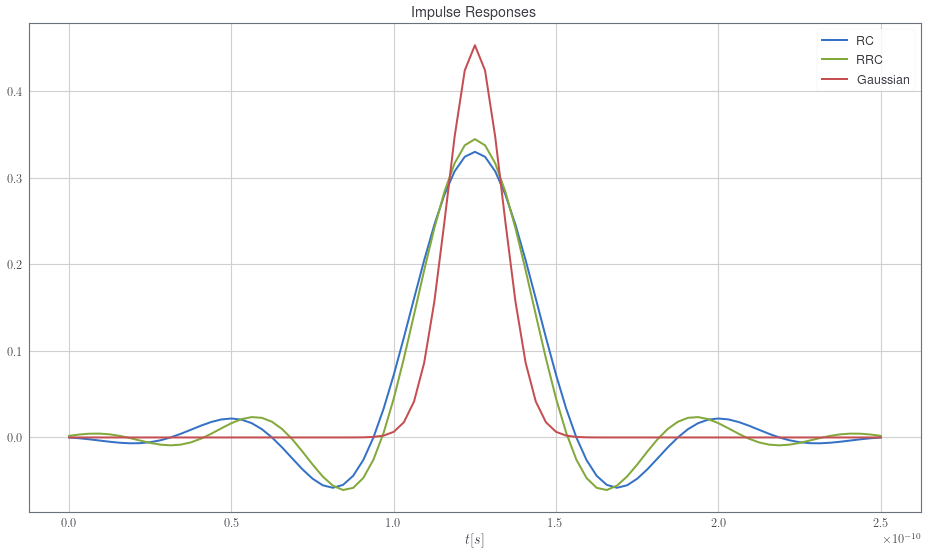

In [2]:
# parameters of the filters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10 # samples per symbol (>1 => oversampling)

r_rc = .33
r_rrc = .33

syms_per_filt = 4  # symbols per filter (plus minus in both directions)

t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)
t_sample_rrc, rrc = get_rrc_ir(syms_per_filt, r_rrc, f_symbol, n_up)
t_sample_gaussian, gaussian = get_gaussian_ir(syms_per_filt, f_symbol, n_up)

fig1 = plt.figure(figsize=(16, 9))
sbplt11 = fig1.add_subplot(111)
rc_plt, = sbplt11.plot(np.arange(rc.size)*t_sample_rc, rc, linewidth=2.0, label='RC')
rrc_plt, = sbplt11.plot(np.arange(rrc.size)*t_sample_rrc, rrc, linewidth=2.0, label='RRC')
gauss_plt, = sbplt11.plot(np.arange(gaussian.size)*t_sample_gaussian, gaussian, linewidth=2.0, label='Gaussian')

sbplt11.grid( True )
sbplt11.legend( loc='upper right' )
sbplt11.set_xlabel('$t[s]$')
sbplt11.set_title( 'Impulse Responses' )

Text(0.5, 1.0, 'Impulse Responses')

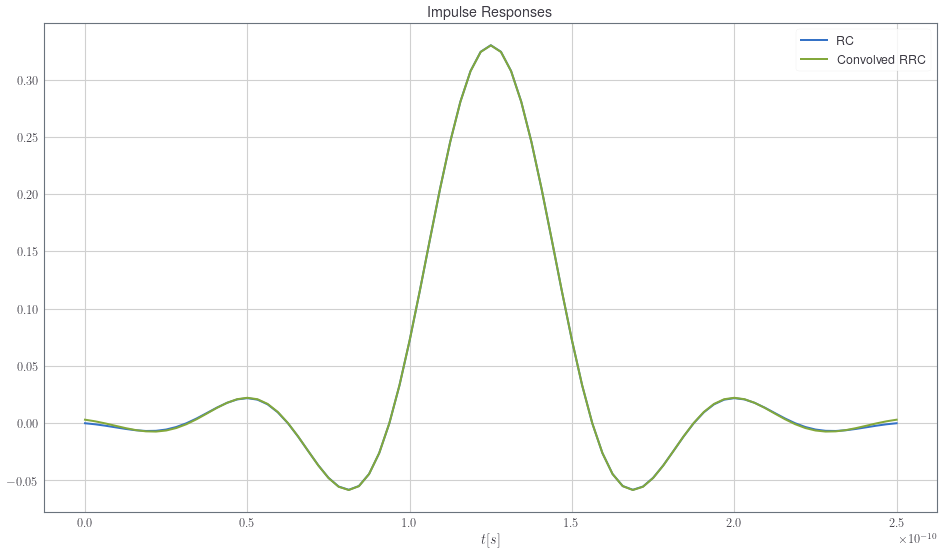

In [3]:
# Comparison of convolved rrc with rc

t_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)
t_rrc, rrc = get_rrc_ir(syms_per_filt, r_rrc, f_symbol, n_up)

rrc_convolved = np.convolve(rrc, rrc, mode='same')
rrc_convolved /= np.linalg.norm(rrc_convolved)

fig2 = plt.figure(figsize=(16, 9))
sbplt21 = fig2.add_subplot(111)
sbplt21.plot(np.arange(rc.size)*t_sample_rc, rc , linewidth=2.0, label='RC')
sbplt21.plot(np.arange(rrc_convolved.size)*t_sample_rrc, rrc_convolved, linewidth=2.0, label='Convolved RRC')

sbplt21.grid( True )
sbplt21.legend(loc='upper right')
sbplt21.set_xlabel('$t[s]$')
sbplt21.set_title('Impulse Responses')


Text(0.5, 1.0, 'Modulation Gaus')

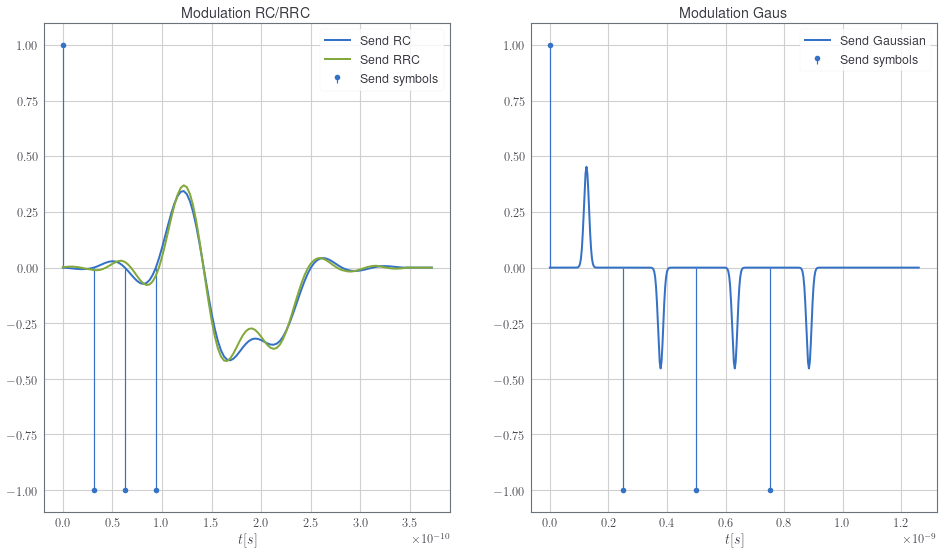

In [4]:
# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 4 # number of symbols

# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)

send_rc = generate_signal(modulation, send_bits, rc, syms_per_filt)
send_rrc = generate_signal(modulation, send_bits, rrc, syms_per_filt)
send_gaussian = generate_signal(modulation, send_bits, gaussian, 0)

fig3 = plt.figure(figsize=(16, 9))
sbplt31 = fig3.add_subplot(121)
sbplt31.plot(np.arange(send_rc.size)*t_sample_rc, send_rc, linewidth=2.0, label='Send RC')
sbplt31.plot(np.arange(send_rrc.size)*t_sample_rrc, send_rrc, linewidth=2.0, label='Send RRC')
sbplt31.stem(np.arange(len(send_bits)/f_symbol, step=1/f_symbol), [ modulation[str(symbol)] for symbol in send_bits ], label='Send symbols', use_line_collection=True, basefmt=' ')

sbplt31.grid( True )
sbplt31.legend(loc='upper right')
sbplt31.set_ylim(-1.1, 1.1)
sbplt31.set_xlabel('$t[s]$')
sbplt31.set_title('Modulation RC/RRC')

sbplt32 = fig3.add_subplot(122)
sbplt32.plot(np.arange(send_gaussian.size)*t_sample_gaussian, send_gaussian, linewidth=2.0, label='Send Gaussian')
sbplt32.stem(np.arange(2*syms_per_filt*n_symbol/f_symbol, step=2*syms_per_filt/f_symbol), [ modulation[str(symbol)] for symbol in send_bits ], label='Send symbols', use_line_collection=True, basefmt=' ')

sbplt32.grid( True )
sbplt32.legend(loc='upper right')
sbplt32.set_ylim(-1.1, 1.1)
sbplt32.set_xlabel('$t[s]$')
sbplt32.set_title('Modulation Gaus')


/home/dominik/.virtualenvs/jupyterlab/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


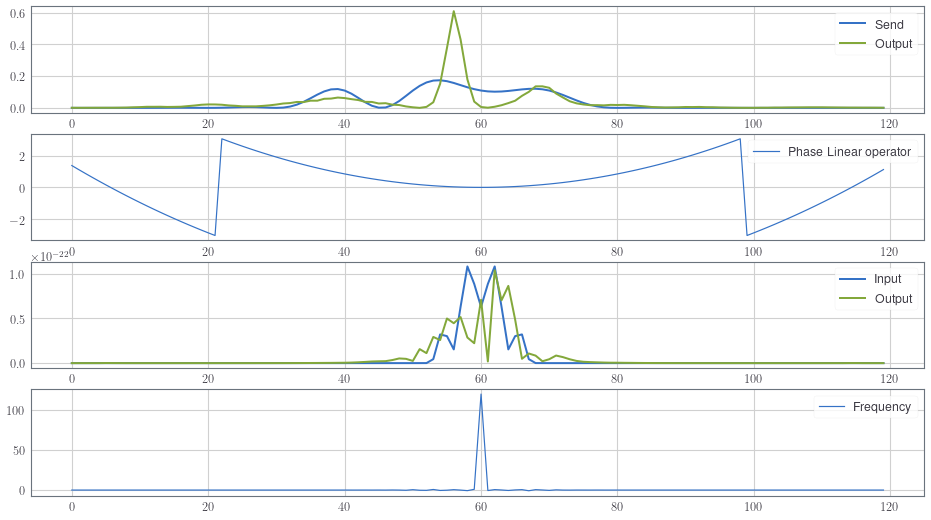

In [5]:
# Transmission
z_length = 70  # [km]
nz = 100  # steps
dz = z_length / nz  # [km]

alpha = 0  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

output, linop, nonlinop = splitstepfourier(send_rrc, t_sample_rrc, dz, nz, alpha, beta2, gamma)

fig4 = plt.figure(figsize=(16, 9))
sbplt41 = fig4.add_subplot(411)
sbplt41.plot(np.square(abs(send_rc)), linewidth=2.0, label='Send')
sbplt41.plot(np.square(abs(output)), linewidth=2.0, label='Output')

sbplt41.grid(True)
sbplt41.legend(loc='upper right')

sbplt42 = fig4.add_subplot(412)
sbplt42.plot(np.fft.fftshift(np.angle(linop)), label='Phase Linear operator')

sbplt42.grid(True)
sbplt42.legend(loc='upper right')

sbplt43 = fig4.add_subplot(413)
sbplt43.plot(np.fft.fftshift(np.square(abs(t_sample_gaussian*np.fft.fft(send_rrc)/np.sqrt(2*np.pi)))), linewidth=2.0, label='Input')
sbplt43.plot(np.fft.fftshift(np.square(abs(t_sample_gaussian*np.fft.fft(output)/np.sqrt(2*np.pi)))), linewidth=2.0, label='Output')

sbplt43.grid(True)
sbplt43.legend(loc='upper right')

sbplt44 = fig4.add_subplot(414)
sbplt44.plot(np.fft.fftshift(np.fft.fft(nonlinop)), label='Frequency')

sbplt44.grid(True)
sbplt44.legend(loc='upper right')